# 0. import library

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, accuracy_score, f1_score
from sklearn import metrics
import pandas as pd
import io
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import time 
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, BaggingRegressor, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import RandomOverSampler
plt.rc("font", size = 14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes = True)

# 1. Data pre-processing

## 1.1. Data converting & split data

In [16]:
raw_data = pd.read_csv('LengthOfStay.csv')

# drop 'eid'
raw_data = raw_data.drop(['eid'], axis=1)

boolean_features_name_list = ["dialysisrenalendstage", "asthma", "irondef", "pneum", "substancedependence", "psychologicaldisordermajor", "depress", 
                                        "psychother", "fibrosisandother", "malnutrition", "hemo"]

numerical_features_name_list = ["hematocrit", "neutrophils", "sodium", "glucose", "bloodureanitro", "creatinine", "bmi", "pulse", 
                                          "respiration", "secondarydiagnosisnonicd9"]

catagory_feature_name_list = ["rcount", "gender", "facid"]

# convert 'vdate', 'discharged' to month and day
raw_data['vdate'] = pd.to_datetime(raw_data['vdate'])
raw_data['vdate_month'] = raw_data['vdate'].dt.month
raw_data['vdate_day'] = raw_data['vdate'].dt.day

raw_data['discharged'] = pd.to_datetime(raw_data['discharged'])
raw_data['discharged_month'] = raw_data['discharged'].dt.month
raw_data['discharged_day'] = raw_data['discharged'].dt.day

for new_cat_feat in ['vdate_month', 'vdate_day', 'discharged_month', 'discharged_day']:
  catagory_feature_name_list.append(new_cat_feat)

raw_data = raw_data.drop(['vdate', 'discharged'], axis=1)

# convert "rcount", "gender", "facid", 'vdate_month', 'vdate_day', 'vdate_month_month', 'vdate_month_day' to category
for cat in catagory_feature_name_list:
    raw_data[cat] = raw_data[cat].astype('category')

# add 1 more feature based on the number of boolean features
raw_data['numberofbooleanfeatures'] = raw_data[boolean_features_name_list].sum(axis=1)
numerical_features_name_list.append('numberofbooleanfeatures')

train_data = raw_data.iloc[:50000, :]
test_data = raw_data.iloc[50000:, :]

train_data_feature = train_data.drop(['lengthofstay'], axis=1)
train_data_label = train_data[['lengthofstay']]

print("train_data_feature.shape", train_data_feature.shape)
print("train_data_label.shape", train_data_label.shape)

print("boolean_features_name_list", boolean_features_name_list)
print("numerical_features_name_list", numerical_features_name_list)
print("catagory_feature_name_list", catagory_feature_name_list)

raw_data.head()

# check if there are null values
raw_data.isnull().sum()

train_data_feature.shape (50000, 29)
train_data_label.shape (50000, 1)
boolean_features_name_list ['dialysisrenalendstage', 'asthma', 'irondef', 'pneum', 'substancedependence', 'psychologicaldisordermajor', 'depress', 'psychother', 'fibrosisandother', 'malnutrition', 'hemo']
numerical_features_name_list ['hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine', 'bmi', 'pulse', 'respiration', 'secondarydiagnosisnonicd9', 'numberofbooleanfeatures']
catagory_feature_name_list ['rcount', 'gender', 'facid', 'vdate_month', 'vdate_day', 'discharged_month', 'discharged_day']


,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,depress,psychother,...,pulse,respiration,secondarydiagnosisnonicd9,facid,lengthofstay,vdate_month,vdate_day,discharged_month,discharged_day,numberofbooleanfeatures
0,0,F,0,0,0,0,0,0,0,0,...,96,6.5,4,B,3,8,29,9,1,0
1,5+,F,0,0,0,0,0,0,0,0,...,61,6.5,1,A,7,5,26,6,2,0
2,1,F,0,0,0,0,0,0,0,0,...,64,6.5,2,B,3,9,22,9,25,0
3,0,F,0,0,0,0,0,0,0,0,...,76,6.5,1,A,1,8,9,8,10,0
4,0,F,0,0,0,1,0,1,0,0,...,67,5.6,2,E,4,12,20,12,24,2


## 1.2. Feature selection

### 1.2.1. Feature selection - Random Forests

In [17]:
cat_idx = []
num_idx = []
bool_idx = []
type_list = []

idx = 0
for feat in train_data_feature.columns.tolist():
  # boolean data
  if feat in boolean_features_name_list:
    bool_idx.append(idx)
    type_list.append('boolean')
  # numeric data
  elif feat in numerical_features_name_list:
    num_idx.append(idx)
    type_list.append('number')
  # catagory data
  else: 
    cat_idx.append(idx)
    type_list.append('catagory')
  idx += 1

print("feat names", train_data_feature.columns.tolist())
print("cat_idx", cat_idx)
print("num_idx", num_idx)
print("bool_idx", bool_idx)
print("type_list", type_list)

column_trans = ColumnTransformer(transformers=
        [('cat', OrdinalEncoder(), cat_idx),
        ('num', StandardScaler(), num_idx),
        ('bool', 'passthrough', bool_idx)],
        remainder='passthrough')

clf = RandomForestClassifier(random_state=4211, n_jobs=-1)

pipeline = Pipeline([('prep', column_trans), ('clf', clf)])

train_x, test_x, train_y, test_y = train_test_split(train_data_feature, train_data_label, test_size=0.3, random_state=4211)
pipeline.fit(train_x, train_y)
pipeline['clf'].feature_importances_

data = {
    "feature": train_x.columns.tolist(),
    "importance": pipeline['clf'].feature_importances_,
    "type": type_list
}
table = pd.DataFrame(data)
table = table.sort_values(by=['importance'], ascending=False)
table['accumulative sum'] = table['importance'].cumsum()
table

feat names ['rcount', 'gender', 'dialysisrenalendstage', 'asthma', 'irondef', 'pneum', 'substancedependence', 'psychologicaldisordermajor', 'depress', 'psychother', 'fibrosisandother', 'malnutrition', 'hemo', 'hematocrit', 'neutrophils', 'sodium', 'glucose', 'bloodureanitro', 'creatinine', 'bmi', 'pulse', 'respiration', 'secondarydiagnosisnonicd9', 'facid', 'vdate_month', 'vdate_day', 'discharged_month', 'discharged_day', 'numberofbooleanfeatures']
cat_idx [0, 1, 23, 24, 25, 26, 27]
num_idx [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 28]
bool_idx [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
type_list ['catagory', 'catagory', 'boolean', 'boolean', 'boolean', 'boolean', 'boolean', 'boolean', 'boolean', 'boolean', 'boolean', 'boolean', 'boolean', 'number', 'number', 'number', 'number', 'number', 'number', 'number', 'number', 'number', 'number', 'catagory', 'catagory', 'catagory', 'catagory', 'catagory', 'number']


/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


,feature,importance,type,accumulative sum
0,rcount,0.209139,catagory,0.209139
10,fibrosisandother,0.067247,boolean,0.276386
12,hemo,0.066772,boolean,0.343158
13,hematocrit,0.065368,number,0.408525
9,psychother,0.065349,boolean,0.473874
14,neutrophils,0.060634,number,0.534507
7,psychologicaldisordermajor,0.060490,boolean,0.594998
17,bloodureanitro,0.052363,number,0.647361
8,depress,0.050707,boolean,0.698068
6,substancedependence,0.039495,boolean,0.737564


### 1.2.2. Feature selection - Correlation Heatmap

numberofbooleanfeatures      0.411586
bloodureanitro               0.148191
hematocrit                   0.060914
respiration                  0.020122
neutrophils                  0.011312
pulse                        0.008061
creatinine                   0.006839
sodium                       0.004100
secondarydiagnosisnonicd9    0.003527
bmi                          0.003327
Name: lengthofstay, dtype: float64


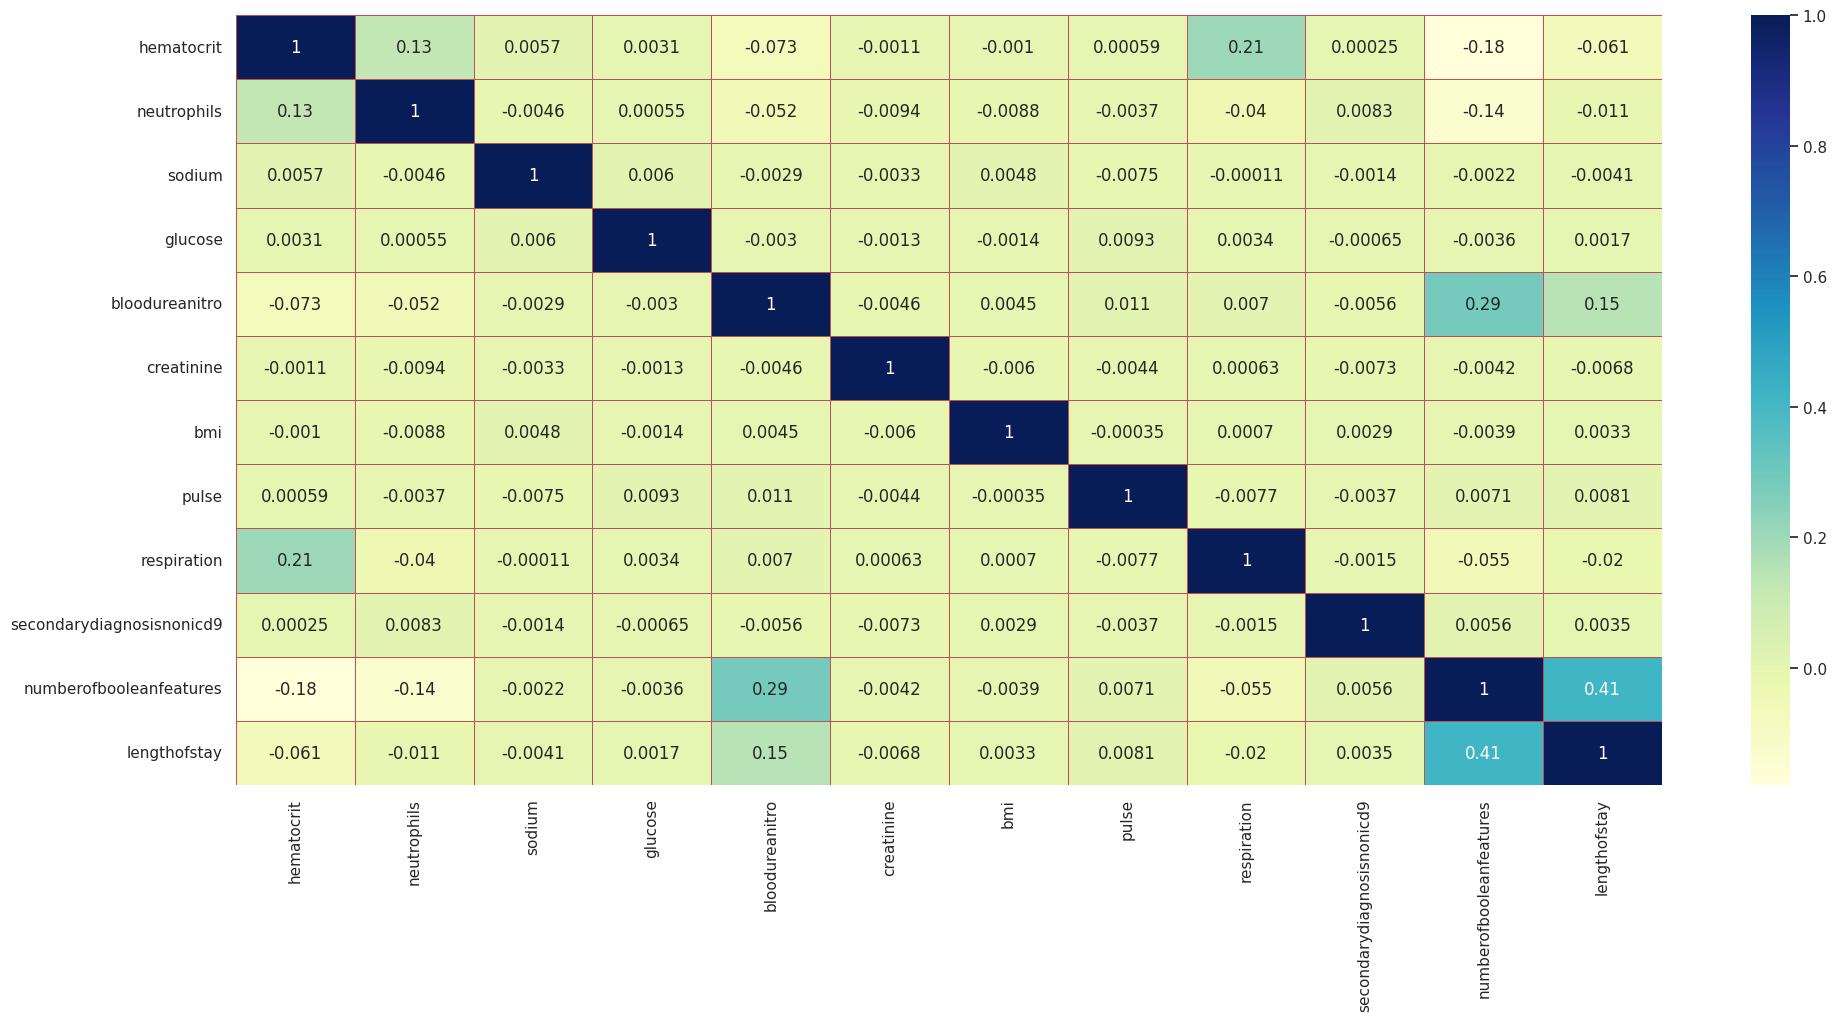

In [18]:
numerical_and_label_name_list = numerical_features_name_list + ['lengthofstay']
train_data_numeric_feature = train_data[numerical_and_label_name_list]

fig, ax = plt.subplots(figsize=(23,10))  
sns.heatmap(train_data_numeric_feature.corr(), annot= True, cmap = 'YlGnBu', linecolor= 'r', linewidths=0.5)

corr_list = abs(train_data_numeric_feature.corr()['lengthofstay']).nlargest(11)[1:]
print(corr_list)

### 1.2.3. Feature selection - conclusion

In [19]:
# select feature if its importance > 0.06 or correlation > 0.15
selected_feature_name = ['rcount', 'fibrosisandother', 'hemo', 'hematocrit', 'psychother', 'neutrophils', 'psychologicaldisordermajor'] + ['numberofbooleanfeatures', 'bloodureanitro']
print(selected_feature_name)

['rcount', 'fibrosisandother', 'hemo', 'hematocrit', 'psychother', 'neutrophils', 'psychologicaldisordermajor', 'numberofbooleanfeatures', 'bloodureanitro']


# 2. Linear Regression

## 2.1. Build & train models

In [24]:
selected_features = pd.get_dummies(data = train_data_feature[selected_feature_name])
selected_feature_name_dummy = selected_features.columns.tolist()

total_number_of_model = len(selected_feature_name_dummy) + 1

# all selected features
sum_features = pd.Series()
for feat in selected_feature_name_dummy:
  sum_features = pd.concat([sum_features, selected_features[feat]])

sum_lengthofstay = pd.Series()
for i in range(total_number_of_model-1):
  sum_lengthofstay = pd.concat([sum_lengthofstay, train_data['lengthofstay']])


trainX, valX = [None] * total_number_of_model, [None] * total_number_of_model
trainY, valY = [None] * total_number_of_model, [None] * total_number_of_model
model, reg, reg_train_time = [None] * total_number_of_model, [None] * total_number_of_model, [None] * total_number_of_model
xfit, yfit = [None] * total_number_of_model, [None] * total_number_of_model
reg_r2, mse = [None] * total_number_of_model, [None] * total_number_of_model

def buildModel(i, x, y):
  trainX[i], valX[i], trainY[i], valY[i] = train_test_split(x, y, test_size = 0.2, random_state = 4211)
  model[i] = LinearRegression()
  start = time.time()
  reg[i] = model[i].fit(trainX[i].to_numpy().reshape(-1, 1), trainY[i])
  end = time.time()
  reg_train_time[i] = end - start

def cal_mse(i):
  reg_r2[i] = reg[i].score(valX[i].to_numpy().reshape(-1, 1), valY[i])
  xfit[i] = np.linspace(valX[i].min(), valX[i].max(), 1000)
  yfit[i] = reg[i].coef_*xfit[i] + reg[i].intercept_
  mse[i] = mean_squared_error(valY[i].to_numpy().reshape(-1, 1), reg[i].predict(valX[i].to_numpy().reshape(-1, 1)))

# build all selected single feature models
idx = 0;
for feature in selected_feature_name_dummy:
  buildModel(idx, selected_features[feature], train_data['lengthofstay'])
  idx = idx + 1

# build combined model
buildModel(idx, sum_features, sum_lengthofstay)

# calculate the mse
idx = 0;
for idx in range(len(reg)):
    cal_mse(idx)
    idx = idx + 1

# for i in range(len(reg)):
#   print(reg[i].predict(valX[i].to_numpy().reshape(-1, 1)))

selected_features.head()

<ipython-input-24-66f53408f76e>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sum_features = pd.Series()
<ipython-input-24-66f53408f76e>:11: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sum_lengthofstay = pd.Series()


,fibrosisandother,hemo,hematocrit,psychother,neutrophils,psychologicaldisordermajor,numberofbooleanfeatures,bloodureanitro,rcount_0,rcount_1,rcount_2,rcount_3,rcount_4,rcount_5+
0,0,0,11.5,0,14.20,0,0,12.0,1,0,0,0,0,0
1,0,0,9.0,0,4.10,0,0,8.0,0,0,0,0,0,1
2,0,0,8.4,0,8.90,0,0,12.0,0,1,0,0,0,0
3,0,0,11.9,0,9.40,0,0,12.0,1,0,0,0,0,0
4,0,0,9.1,0,9.05,1,2,11.5,1,0,0,0,0,0


## 2.2. Prediction

predition for fibrosisandother
[3.99577911 3.99577911 3.99577911 ... 3.99577911 3.99577911 3.99577911]
predition for hemo
[3.85478566 3.85478566 3.85478566 ... 3.85478566 3.85478566 3.85478566]
predition for hematocrit
[3.83726945 4.01027849 4.34245586 ... 4.21096899 4.01027849 4.14176537]
predition for psychother
[3.90279203 3.90279203 3.90279203 ... 3.90279203 3.90279203 3.90279203]
predition for neutrophils
[3.98289629 4.00893343 3.98211906 ... 4.03225028 4.00893343 4.01864879]
predition for psychologicaldisordermajor
[3.6410021 3.6410021 3.6410021 ... 3.6410021 3.6410021 3.6410021]
predition for numberofbooleanfeatures
[3.35142461 3.35142461 3.35142461 ... 6.00751659 3.35142461 3.35142461]
predition for bloodureanitro
[3.95188185 3.95188185 3.95188185 ... 3.90123541 3.95188185 3.95188185]
predition for rcount_0
[2.72423651 2.72423651 2.72423651 ... 5.57796582 2.72423651 5.57796582]
predition for rcount_1
[4.05687998 4.05687998 4.05687998 ... 4.05687998 4.05687998 4.05687998]
predit

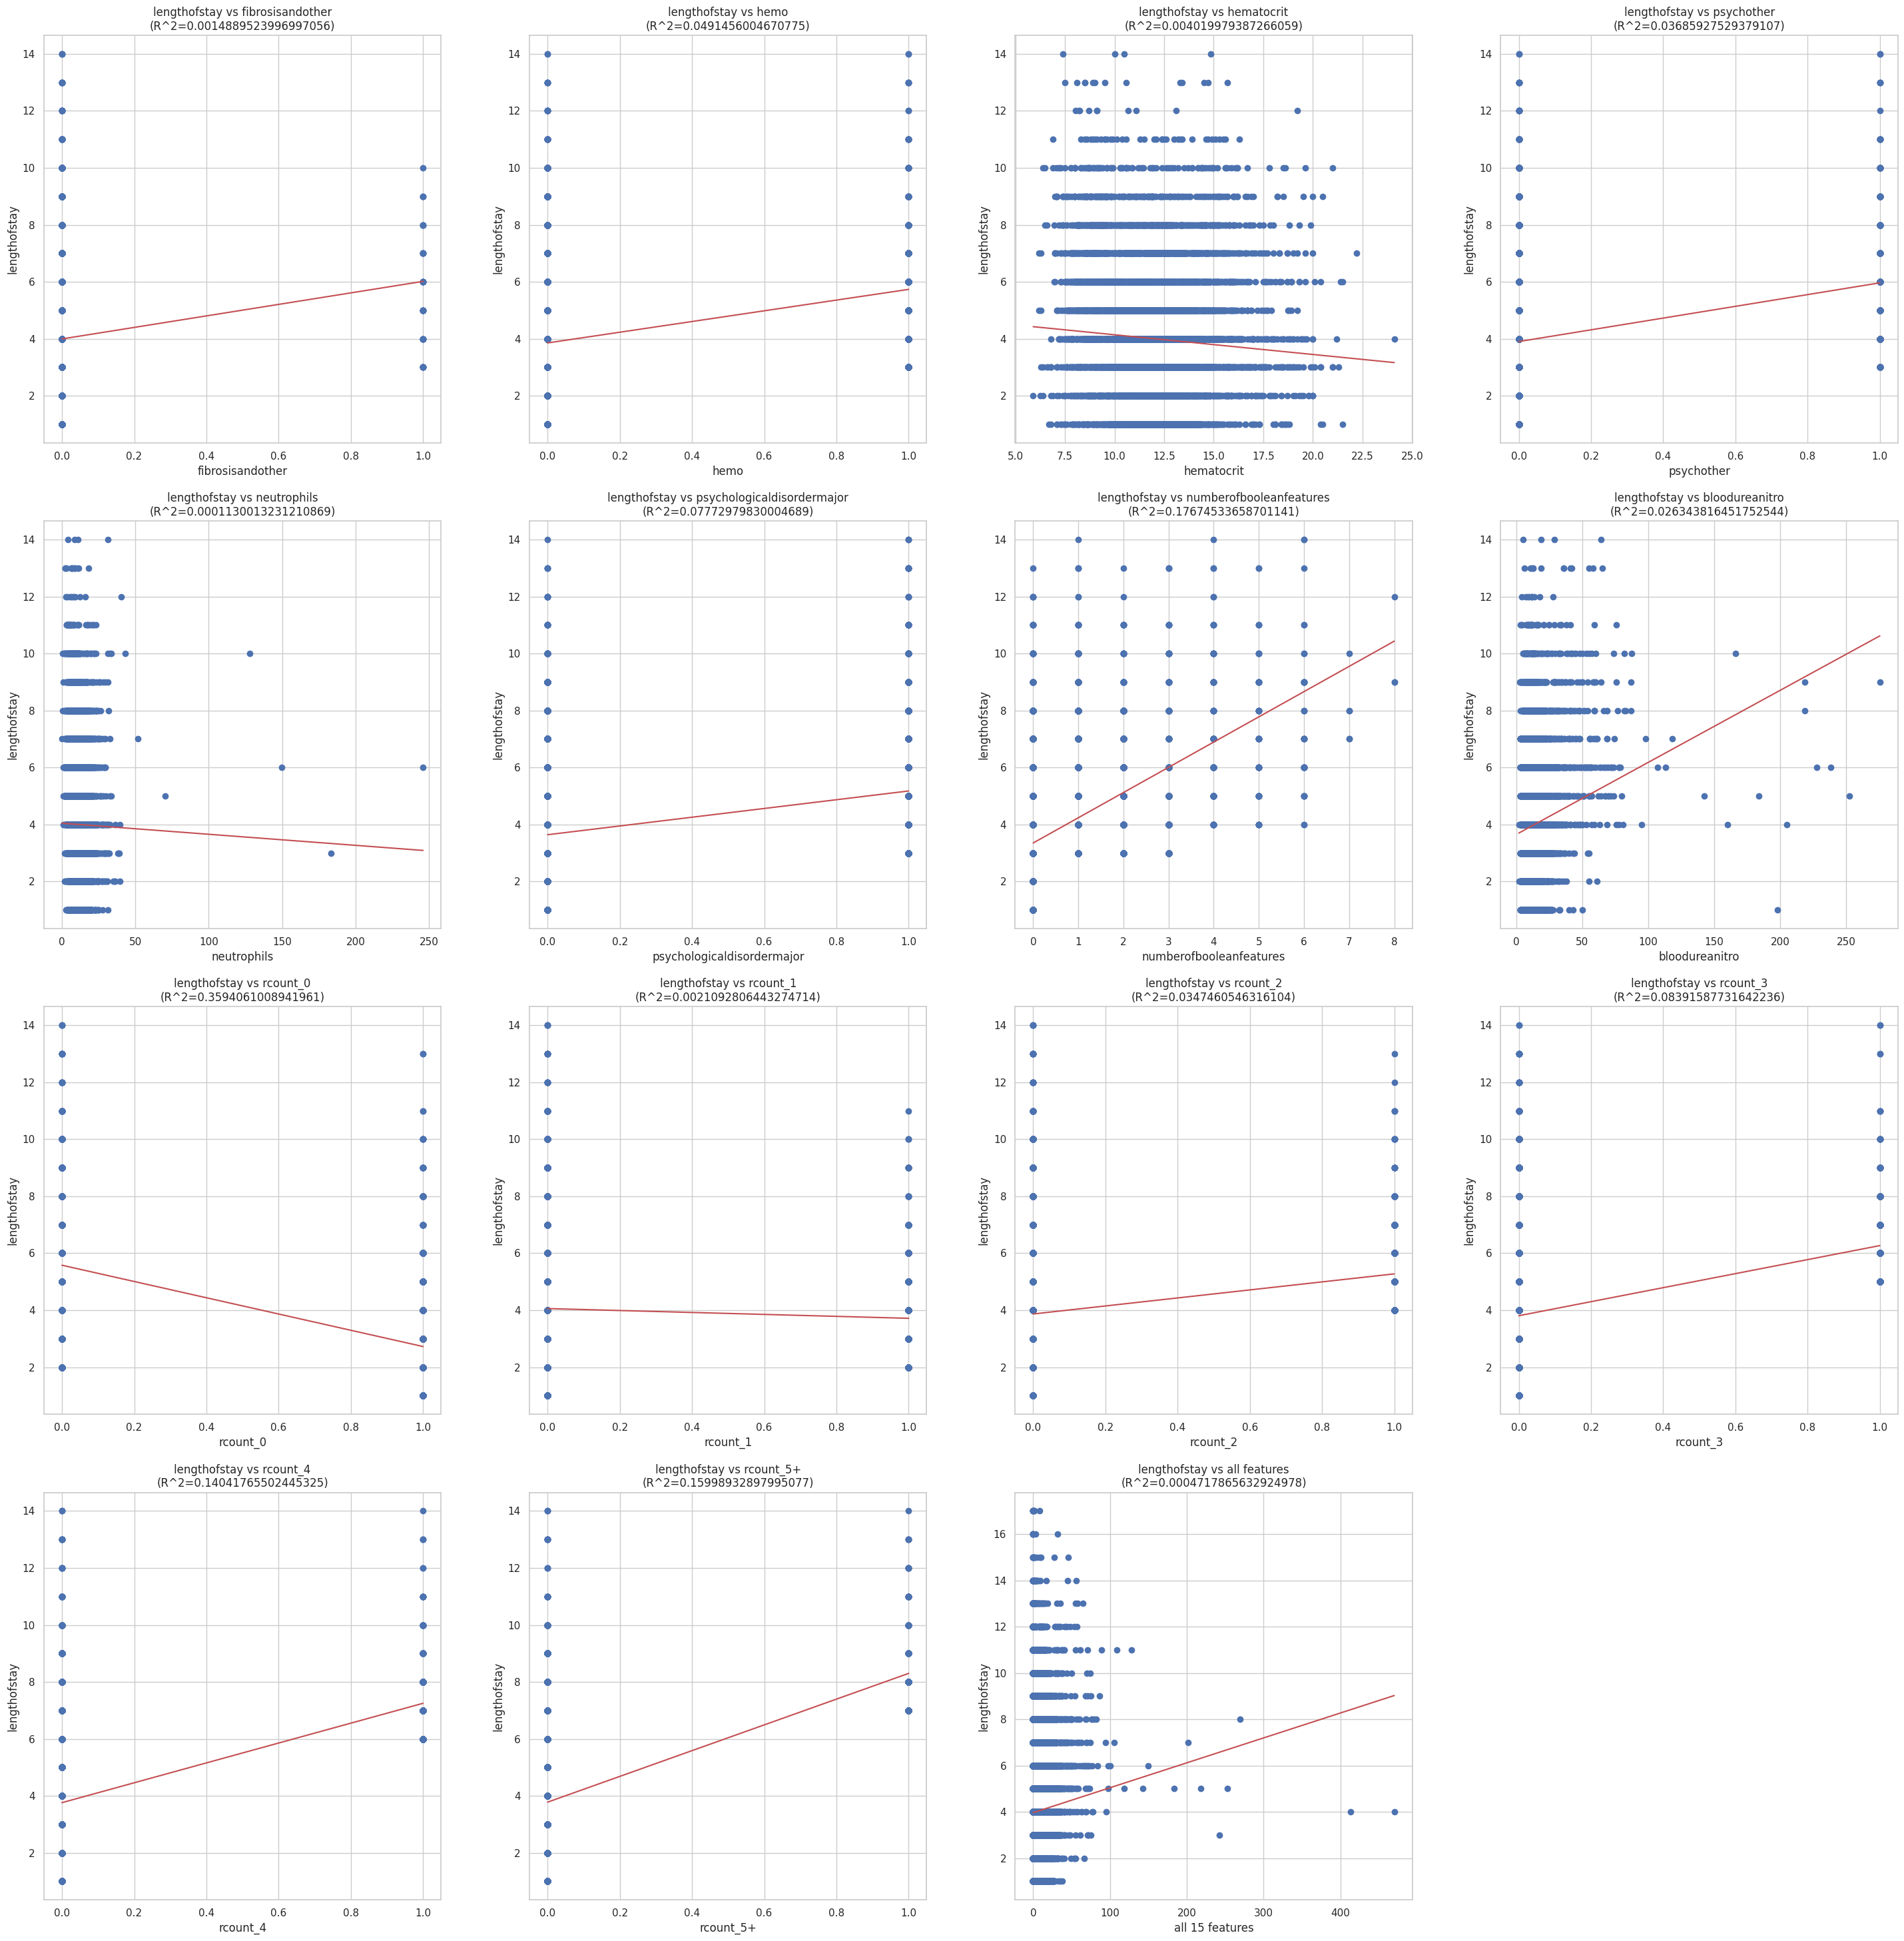

In [25]:
fig, axs = plt.subplots(4,4)
fig.set_size_inches([30,30])
fig.tight_layout(pad=5.0)

idx = 0;
xfit, yfit, r2, mse = [None] * total_number_of_model, [None] * total_number_of_model, [None] * total_number_of_model, [None] * total_number_of_model
for i,ax in enumerate(axs.flat):
  if idx <=total_number_of_model-1:
    ax.scatter(valX[idx], valY[idx])
    r2[idx] = reg[idx].score(valX[idx].to_numpy().reshape(-1, 1), valY[idx])
    
    if idx < total_number_of_model-1:
      ax.set_title(f'lengthofstay vs {selected_feature_name_dummy[idx]}\n(R^2={r2[idx]})')
      ax.set(xlabel= selected_feature_name_dummy[idx] ,ylabel="lengthofstay")
    else:
      ax.set_title(f'lengthofstay vs all features\n(R^2={r2[idx]})')
      ax.set(xlabel=f"all {total_number_of_model} features" ,ylabel="lengthofstay")

    
    xfit[idx] = np.linspace(valX[idx].min(), valX[idx].max(), 1000)
    yfit[idx] = reg[idx].coef_*xfit[idx] + reg[idx].intercept_
    predition = reg[idx].predict(valX[idx].to_numpy().reshape(-1, 1))
    if idx < total_number_of_model-1:
      print(f"predition for {selected_feature_name_dummy[idx]}")
    else:
      print(f"predition for all selected features")
    print(predition)

    mse[idx] = mean_squared_error(valY[idx].to_numpy().reshape(-1, 1), predition)
    ax.plot(xfit[idx], yfit[idx], 'r')
  else:
    ax.set_visible(False)

  idx = idx + 1

plt.show()

## 2.3. Evaluation

['fibrosisandother', 'hemo', 'hematocrit', 'psychother', 'neutrophils', 'psychologicaldisordermajor', 'numberofbooleanfeatures', 'bloodureanitro', 'rcount_0', 'rcount_1', 'rcount_2', 'rcount_3', 'rcount_4', 'rcount_5+']
r2 score: [0.0014889523996997056, 0.0491456004670775, 0.004019979387266059, 0.03685927529379107, 0.0001130013231210869, 0.07772979830004689, 0.17674533658701141, 0.026343816451752544, 0.3594061008941961, 0.0021092806443274714, 0.0347460546316104, 0.08391587731642236, 0.14041765502445325, 0.15998932897995077, 0.0004717865632924978]
mse: [5.548502614459515, 5.283685277652172, 5.534438263452554, 5.351957639294953, 5.5561484669156425, 5.124849282006838, 4.574642076610692, 5.410389692718408, 3.5596370541291735, 5.545055589115718, 5.363700333977418, 5.090474624181968, 4.776506879820954, 4.667751464072267, 5.57334980712837]
reg_train_time: [0.002826690673828125, 0.0025374889373779297, 0.002797842025756836, 0.009511232376098633, 0.002608060836791992, 0.0023806095123291016, 0.00

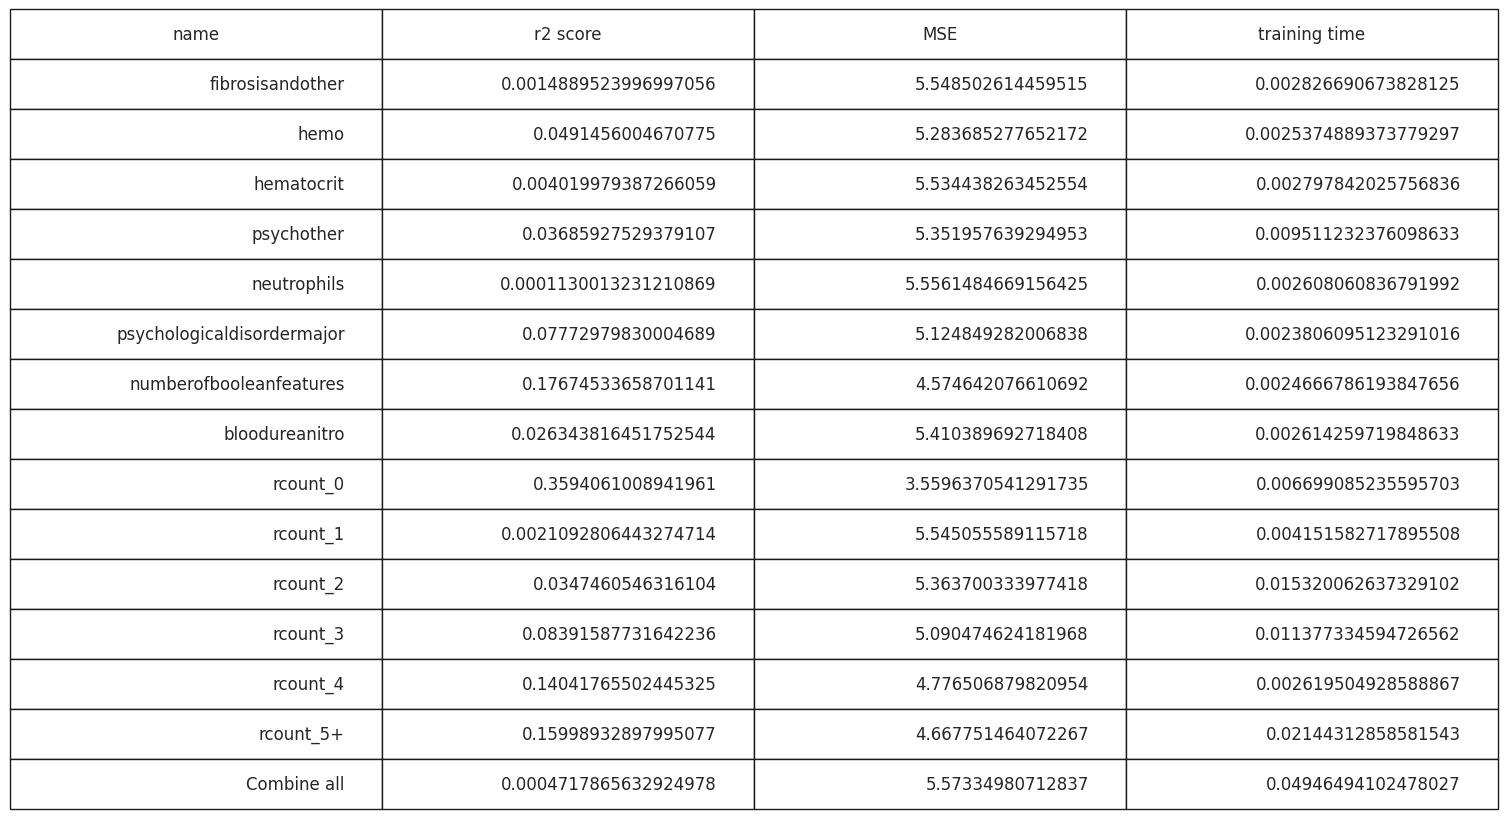

In [26]:
print(selected_feature_name_dummy)
print(f'r2 score: {reg_r2}')
print(f'mse: {mse}')
print(f'reg_train_time: {reg_train_time}')

linear_regression_r2 = reg_r2

fig, axs = plt.subplots(1, 1)
data = [selected_feature_name_dummy + ['Combine all'], reg_r2, mse, reg_train_time]
data = np.array(data).transpose()
columns = ("name", "r2 score", "MSE", "training time")
axs.axis('off')
the_table = axs.table(cellText=data, colLabels=columns, loc='center')
the_table.scale(3, 3)
plt.show()

# 3. Feedforward Neural Networks

## 3.1. Feedforward Neural Networks without bagging

### 3.1. Build & train model

In [27]:
hidden_unit_num = [1, 4, 16, 64, 128]
mlp_reg = [None]*len(hidden_unit_num)

train_data_for_NN = train_data.copy(deep=True)

numerical_selected_features_name_list = ['hematocrit', 'neutrophils', 'numberofbooleanfeatures', 'bloodureanitro']

train_data_for_NN[numerical_selected_features_name_list] = preprocessing.scale(train_data_for_NN[numerical_selected_features_name_list])

selected_features_for_NN = pd.get_dummies(data = train_data_for_NN[selected_feature_name])

selected_features_names_for_NN = selected_features_for_NN.columns.tolist()

grid_result_nn = [None] * 5

for i in range(len(hidden_unit_num)):
  param = {
    'hidden_layer_sizes': [(hidden_unit_num[i], hidden_unit_num[i], hidden_unit_num[i])],
    'learning_rate': ['constant'],
    'max_iter': [300],
    'learning_rate_init': [0.1],
    'solver': ['adam'],
    'verbose': [10]
  }
  mlp_reg[i] = MLPRegressor(random_state=4211, early_stopping=True)
  grid_search_nn = GridSearchCV(mlp_reg[i], param, cv=3, scoring='r2')
  grid_search_nn.fit(selected_features_for_NN, train_data['lengthofstay'])
  grid_result_nn[i] = grid_search_nn.cv_results_

Iteration 1, loss = 1.17620483
Validation score: 0.650789
Iteration 2, loss = 0.89274446
Validation score: 0.678994
Iteration 3, loss = 0.84461440
Validation score: 0.658261
Iteration 4, loss = 0.78541793
Validation score: 0.727481
Iteration 5, loss = 0.77761535
Validation score: 0.722299
Iteration 6, loss = 0.76901336
Validation score: 0.719758
Iteration 7, loss = 0.74494121
Validation score: 0.717251
Iteration 8, loss = 0.75130348
Validation score: 0.719041
Iteration 9, loss = 0.74170000
Validation score: 0.729659
Iteration 10, loss = 0.74675764
Validation score: 0.733259
Iteration 11, loss = 0.74753472
Validation score: 0.687621
Iteration 12, loss = 0.74180396
Validation score: 0.731751
Iteration 13, loss = 0.73951659
Validation score: 0.731902
Iteration 14, loss = 0.74765674
Validation score: 0.728551
Iteration 15, loss = 0.74795823
Validation score: 0.725809
Iteration 16, loss = 0.75561338
Validation score: 0.707040
Iteration 17, loss = 0.74599494
Validation score: 0.731934
Iterat

### 3.2. Evaluation

{'mean_fit_time': array([3.1632088]), 'std_fit_time': array([0.65572713]), 'mean_test_score': array([0.74412435]), 'std_test_score': array([0.00404632])}
{'mean_fit_time': array([2.50589228]), 'std_fit_time': array([0.29219946]), 'mean_test_score': array([0.79470781]), 'std_test_score': array([0.00352011])}
{'mean_fit_time': array([3.36208089]), 'std_fit_time': array([0.54278674]), 'mean_test_score': array([0.81868109]), 'std_test_score': array([0.00264607])}
{'mean_fit_time': array([8.90058724]), 'std_fit_time': array([2.31639065]), 'mean_test_score': array([0.82011764]), 'std_test_score': array([0.00106441])}
{'mean_fit_time': array([16.86312922]), 'std_fit_time': array([6.11160496]), 'mean_test_score': array([0.81366162]), 'std_test_score': array([0.00051719])}


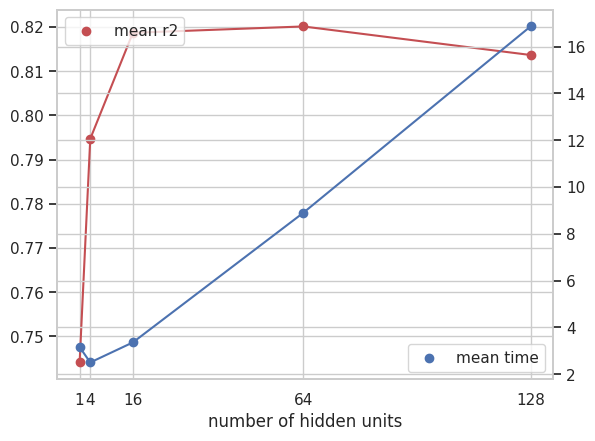

In [28]:
fnn_r2 = []
fnn_time = []

def report(report):
  result = {
      'mean_fit_time': report['mean_fit_time'],
      'std_fit_time': report['std_fit_time'],
      'mean_test_score': report['mean_test_score'],
      'std_test_score': report['std_test_score']
  }
  fnn_r2.append(report['mean_test_score'])
  fnn_time.append(report['mean_fit_time'])
  return result

report_mlp = [None] * 5
for i in range(len(grid_result_nn)):
  report_mlp[i] = report(grid_result_nn[i])
  print(report_mlp[i])

neural_network_r2 = fnn_r2

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.scatter(hidden_unit_num, fnn_r2, label='mean r2', c='r')
ax2.scatter(hidden_unit_num, fnn_time, label='mean time', c='b')
ax.legend(loc='upper left')
ax2.legend(loc='lower right')
plt.xticks(hidden_unit_num)
ax.set_xlabel("number of hidden units")
ax.plot(hidden_unit_num, fnn_r2, 'r')
ax2.plot(hidden_unit_num, fnn_time, 'b')
plt.show()

# 4. Decision tree

## 4.1. Decision tree without bagging

### 4.1.1. Build & train model

In [29]:
train_data_for_DT = train_data.copy(deep=True)

numerical_selected_features_name_list = ['hematocrit', 'neutrophils', 'numberofbooleanfeatures', 'bloodureanitro']
tree_depth = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
train_data_for_DT[numerical_selected_features_name_list] = preprocessing.scale(train_data_for_NN[numerical_selected_features_name_list])
selected_features_for_DT = pd.get_dummies(data = train_data_for_NN[selected_feature_name])
selected_features_names_for_DT = selected_features_for_NN.columns.tolist()


def buildTrainDecisionTreeRegressor(tree_depth_list):
  param_grid = {
      'max_depth': tree_depth_list,
  }
  dt_reg = DecisionTreeRegressor(random_state=4211)
  grid_search = GridSearchCV(dt_reg, param_grid, cv=3, scoring='r2')
  grid_search.fit(selected_features_for_DT, train_data['lengthofstay'])
  grid_result = grid_search.cv_results_
  return dt_reg, grid_result

dt_reg, grid_result = buildTrainDecisionTreeRegressor(tree_depth)



### 4.1.2. Evaluation

{'mean_fit_time': array([0.01170778, 0.0210909 , 0.0298806 , 0.03757135, 0.05041281,
       0.05293107, 0.19348288, 0.08150268, 0.07652322, 0.21630526]), 'std_fit_time': array([0.00082925, 0.00017892, 0.00050447, 0.00234057, 0.00327373,
       0.00090688, 0.08037883, 0.01086931, 0.00114362, 0.10376467]), 'mean_test_score': array([0.36165715, 0.7357507 , 0.80187888, 0.82136094, 0.81920227,
       0.80786199, 0.79117475, 0.77224481, 0.75412615, 0.73617551]), 'std_test_score': array([0.00200562, 0.00374508, 0.00422616, 0.00339698, 0.00290414,
       0.00081401, 0.0012958 , 0.00328325, 0.00141766, 0.00138079])}


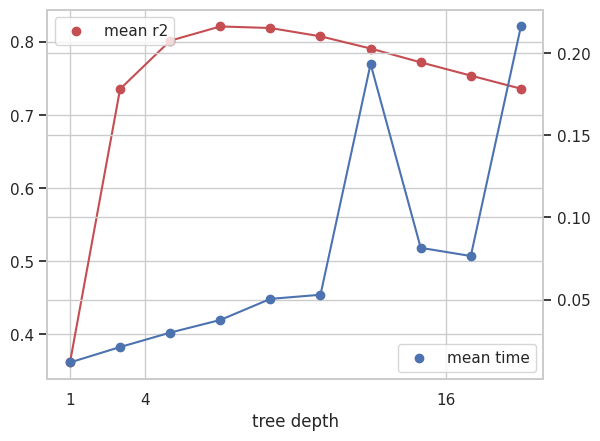

In [30]:
def report(report):
  result = {
      'mean_fit_time': report['mean_fit_time'],
      'std_fit_time': report['std_fit_time'],
      'mean_test_score': report['mean_test_score'],
      'std_test_score': report['std_test_score']
  }
  return result

report_dt= report(grid_result)
decision_tree_without_bagging_r2 = report_dt['mean_test_score']
print(report_dt)

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.scatter(tree_depth, report_dt['mean_test_score'].tolist(), label='mean r2', c='r')
ax2.scatter(tree_depth, report_dt['mean_fit_time'].tolist(), label='mean time', c='b')
ax.legend(loc='upper left')
ax2.legend(loc='lower right')
plt.xticks(hidden_unit_num)
ax.set_xlabel("tree depth")
ax.plot(tree_depth, report_dt['mean_test_score'], 'r')
ax2.plot(tree_depth, report_dt['mean_fit_time'].tolist(), 'b')
plt.show()

## 4.2 Decision tree with bagging

### 4.2.1. Build & train model

In [31]:
train_data_for_DT = train_data.copy(deep=True)

numerical_selected_features_name_list = ['hematocrit', 'neutrophils', 'numberofbooleanfeatures', 'bloodureanitro']
tree_depth = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
num_estimator = [2, 5, 8, 11]

train_data_for_DT[numerical_selected_features_name_list] = preprocessing.scale(train_data_for_NN[numerical_selected_features_name_list])
selected_features_for_DT = pd.get_dummies(data = train_data_for_NN[selected_feature_name])
selected_features_names_for_DT = selected_features_for_NN.columns.tolist()

def buildTrainDecisionTreeRegressorWithBagging(tree_depth_list, num_estimator_list):
  param_grid = {
      'estimator__max_depth': tree_depth_list,
      'n_estimators': num_estimator_list
  }
  dt_reg = DecisionTreeRegressor(random_state=4211)
  bagging_reg = BaggingRegressor(estimator=dt_reg, random_state=4211)
  grid_search = GridSearchCV(bagging_reg, param_grid, cv=3, scoring='r2')
  grid_search.fit(selected_features_for_DT, train_data['lengthofstay'])
  grid_result = grid_search.cv_results_

  return dt_reg, grid_result

dt_bagging_reg, grid_result = buildTrainDecisionTreeRegressorWithBagging(tree_depth, num_estimator)


### 4.2.2. Evaluation

{'mean_fit_time': array([0.02636154, 0.05336595, 0.08267649, 0.07793681, 0.03139822,
       0.06830851, 0.11414067, 0.14776937, 0.04307294, 0.10152896,
       0.15727051, 0.21036919, 0.05627759, 0.12556314, 0.19936419,
       0.27515817, 0.0658114 , 0.15098802, 0.24041621, 0.32814654,
       0.07641633, 0.18134689, 0.29630534, 0.47561948, 0.11836211,
       0.29418031, 0.35536671, 0.45534277, 0.09291156, 0.2269822 ,
       0.36392132, 0.49656987, 0.10281062, 0.25969108, 0.39760367,
       0.59037034, 0.32266068, 0.75824078, 0.51717075, 1.01227196]), 'std_fit_time': array([1.03052263e-03, 1.96260154e-04, 2.68003188e-03, 3.53317834e-03,
       1.23974911e-03, 1.40078727e-03, 4.66011006e-03, 2.42218625e-03,
       3.09560306e-04, 4.10657023e-03, 3.29894175e-03, 2.01211761e-03,
       2.29893492e-03, 1.30646743e-03, 3.99659569e-03, 8.58903599e-03,
       4.77589322e-03, 1.11557852e-03, 4.71579350e-03, 2.94275058e-03,
       1.92740273e-03, 5.10259656e-03, 1.10171614e-02, 6.76068448e-02,
  

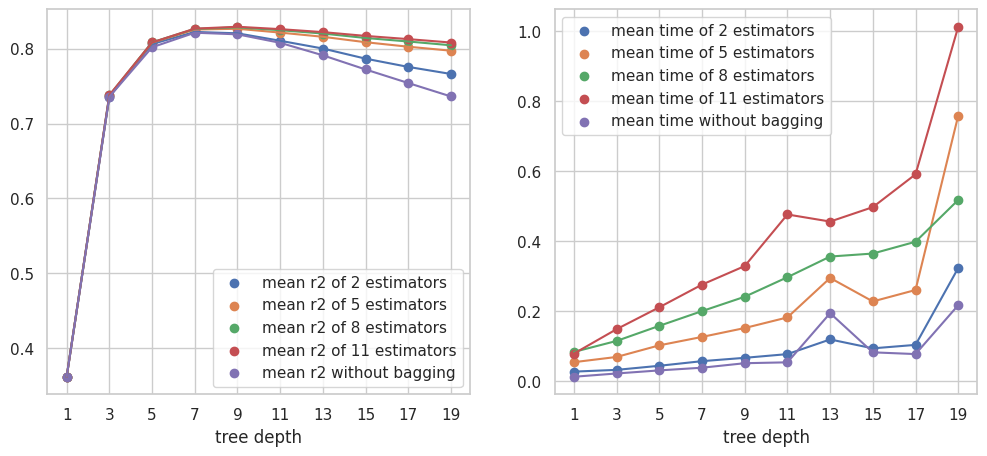

In [33]:
def report(report):
  result = {
      'mean_fit_time': report['mean_fit_time'],
      'std_fit_time': report['std_fit_time'],
      'mean_test_score': report['mean_test_score'],
      'std_test_score': report['std_test_score']
  }
  return result

def slice_list_to_n_lists(lst, n):
    list_2d = []
    for i in range(n):
      list_2d.append([])
    for i in range(len(lst)):
      if (i < n):
        list_2d[i].append(lst[i])
      else:
        list_2d[i%n].append(lst[i])
    return list_2d

report_dt_bagging = report(grid_result)

decision_tree_with_bagging_r2 = report_dt_bagging['mean_test_score']
print(report_dt_bagging)

estimator_score = slice_list_to_n_lists(report_dt_bagging['mean_test_score'], len(num_estimator))
estimator_time = slice_list_to_n_lists(report_dt_bagging['mean_fit_time'], len(num_estimator))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

for i in range(len(num_estimator)):
    ax[0].scatter(tree_depth, estimator_score[i], label=f'mean r2 of {num_estimator[i]} estimators')
    ax[0].plot(tree_depth, estimator_score[i])

ax[0].scatter(tree_depth, report_dt['mean_test_score'].tolist(), label='mean r2 without bagging')
ax[0].plot(tree_depth, report_dt['mean_test_score'].tolist())
ax[0].legend()
ax[0].set_xticks(tree_depth)
ax[0].set_xlabel("tree depth")

for i in range(len(num_estimator)):
    ax[1].scatter(tree_depth, estimator_time[i], label=f'mean time of {num_estimator[i]} estimators')
    ax[1].plot(tree_depth, estimator_time[i])

ax[1].scatter(tree_depth, report_dt['mean_fit_time'].tolist(), label='mean time without bagging')
ax[1].plot(tree_depth, report_dt['mean_fit_time'].tolist())
ax[1].legend()
ax[1].set_xticks(tree_depth)
ax[1].set_xlabel("tree depth")

plt.show()


# 5. Gradient boosting tree

## 5.1. Gradient boosting tree without bagging

### 5.1.1 Build and Train model

In [39]:
train_data_for_GBT = train_data.copy(deep=True)

numerical_selected_features_name_list = ['hematocrit', 'neutrophils', 'numberofbooleanfeatures', 'bloodureanitro']
tree_depth = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
num_estimator_gbt = [1, 5, 10, 30, 50]
# num_estimator_bagging = [2, 5, 8, 11]
train_data_for_GBT[numerical_selected_features_name_list] = preprocessing.scale(train_data_for_GBT[numerical_selected_features_name_list])
selected_features_for_GBT = pd.get_dummies(data = train_data_for_GBT[selected_feature_name])
selected_features_names_for_GBT = selected_features_for_GBT.columns.tolist()

def BuildTrainGradientBoostingRegressor(tree_depth_list, num_estimator_gbt_list):
  param_grid = {
      'max_depth': tree_depth_list,
      'n_estimators': num_estimator_gbt_list,
      'random_state': [4211]
  }
  gbt_reg = GradientBoostingRegressor(random_state=4211)
  grid_search = GridSearchCV(gbt_reg, param_grid, cv=3, scoring='r2')
  grid_search.fit(selected_features_for_GBT, train_data['lengthofstay'])
  grid_result = grid_search.cv_results_
  return gbt_reg, grid_result

gbt_reg, grid_result = BuildTrainGradientBoostingRegressor(tree_depth, num_estimator_gbt)


### 5.1.2. Evaluation

{'mean_fit_time': array([0.01326307, 0.0391349 , 0.07193017, 0.21309137, 0.33720589,
       0.02323302, 0.09021123, 0.17345794, 0.515896  , 0.85669915,
       0.0467542 , 0.19560973, 0.37273486, 0.83340406, 1.34380563,
       0.04093035, 0.17878429, 0.35200644, 1.1864357 , 1.84367426,
       0.04884235, 0.22685512, 0.42933075, 1.51168307, 2.50491492,
       0.05847899, 0.27107692, 0.53526433, 1.80373192, 2.66965779,
       0.09548481, 0.43441089, 0.61534413, 1.81015468, 3.27143375,
       0.08088891, 0.3510797 , 0.68768771, 2.32073863, 3.68238521,
       0.08133531, 0.38569951, 0.7764682 , 2.72613454, 4.11870337,
       0.09557422, 0.43333705, 0.85716168, 2.8462228 , 4.49969355]), 'std_fit_time': array([1.00954952e-03, 3.40897236e-04, 8.56503008e-04, 3.01579905e-03,
       2.65131499e-03, 4.48369041e-04, 9.10513808e-04, 2.62586495e-03,
       5.75571258e-03, 1.00989155e-02, 7.27169535e-04, 5.19811094e-03,
       1.32484472e-03, 7.39925150e-02, 1.57625673e-02, 1.23685505e-03,
       7.8

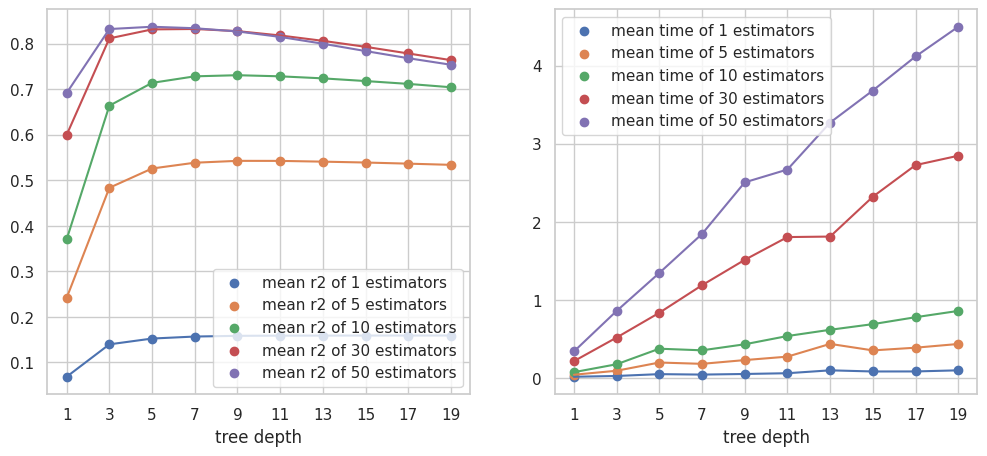

In [40]:
def report(report):
  result = {
      'mean_fit_time': report['mean_fit_time'],
      'std_fit_time': report['std_fit_time'],
      'mean_test_score': report['mean_test_score'],
      'std_test_score': report['std_test_score']
  }
  return result

def slice_list_to_n_lists(lst, n):
    list_2d = []
    for i in range(n):
      list_2d.append([])
    for i in range(len(lst)):
      if (i < n):
        list_2d[i].append(lst[i])
      else:
        list_2d[i%n].append(lst[i])
    return list_2d

report_gbt = report(grid_result)

gradient_boosting_tree_without_bagging_r2 = report_gbt['mean_test_score']
print(report_gbt)

estimator_score = slice_list_to_n_lists(report_gbt['mean_test_score'], len(num_estimator_gbt))
estimator_time = slice_list_to_n_lists(report_gbt['mean_fit_time'], len(num_estimator_gbt))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

for i in range(len(num_estimator_gbt)):
    ax[0].scatter(tree_depth, estimator_score[i], label=f'mean r2 of {num_estimator_gbt[i]} estimators')
    ax[0].plot(tree_depth, estimator_score[i])

ax[0].legend()
ax[0].set_xticks(tree_depth)
ax[0].set_xlabel("tree depth")

for i in range(len(num_estimator_gbt)):
    ax[1].scatter(tree_depth, estimator_time[i], label=f'mean time of {num_estimator_gbt[i]} estimators')
    ax[1].plot(tree_depth, estimator_time[i])

ax[1].legend()
ax[1].set_xticks(tree_depth)
ax[1].set_xlabel("tree depth")

plt.show()

## 5.2. Gradient boosting tree with bagging

### 5.2.1 Build and train model

In [49]:
train_data_for_GBT_bagging = train_data.copy(deep=True)

numerical_selected_features_name_list = ['hematocrit', 'neutrophils', 'numberofbooleanfeatures', 'bloodureanitro']
tree_depth = [3, 4, 5, 6, 7]
num_estimator_gbt = [50]
num_estimator_bagging = [2, 5, 8, 11]
train_data_for_GBT_bagging[numerical_selected_features_name_list] = preprocessing.scale(train_data_for_GBT_bagging[numerical_selected_features_name_list])
selected_features_for_GBT = pd.get_dummies(data = train_data_for_GBT_bagging[selected_feature_name])
selected_features_names_for_GBT = selected_features_for_GBT.columns.tolist()

def BuildTrainGradientBoostingRegressorWithBagging(tree_depth_list, num_estimator_gbt_list, num_estimator_bagging_list):
  param_grid = {
      'estimator__max_depth': tree_depth_list,
      'estimator__n_estimators': num_estimator_gbt_list,
      'n_estimators': num_estimator_bagging_list
  }
  gbt_reg = GradientBoostingRegressor(random_state=4211)
  bagging_reg = BaggingRegressor(estimator=gbt_reg, random_state=4211)
  grid_search = GridSearchCV(bagging_reg, param_grid, cv=3, scoring='r2')
  grid_search.fit(selected_features_for_GBT, train_data['lengthofstay'])
  grid_result = grid_search.cv_results_

  return bagging_reg, grid_result
gbt_bagging_reg, grid_result = BuildTrainGradientBoostingRegressorWithBagging(tree_depth, num_estimator_gbt, num_estimator_bagging)

### 5.2.2 Evaluation



{'mean_fit_time': array([ 1.18689418,  3.2495393 ,  8.14397947,  7.57049576,  1.57896678,
        5.2917041 ,  7.85810375,  9.99082398,  1.98521233,  4.89448786,
        8.31081247, 10.57964238,  2.47097262,  6.60380777, 10.03600574,
       13.28709245,  3.84289598,  7.13860639, 10.23310304, 18.84281953]), 'std_fit_time': array([0.0177528 , 0.06203875, 2.50067468, 0.99581758, 0.0497916 ,
       0.33277519, 0.53564624, 0.36518183, 0.23692745, 0.29229947,
       0.81352873, 0.23179899, 0.28895803, 1.18033036, 1.27946713,
       0.60360796, 0.49272947, 0.28096996, 0.44392029, 3.13106573]), 'mean_test_score': array([0.83180945, 0.83197979, 0.83199064, 0.83201808, 0.83572261,
       0.83613181, 0.83622276, 0.83626638, 0.83613931, 0.83691199,
       0.83709968, 0.83716719, 0.8348739 , 0.83621726, 0.83653893,
       0.83669838, 0.8324503 , 0.83450072, 0.83502312, 0.83529301]), 'std_test_score': array([0.0032084 , 0.0031304 , 0.00306146, 0.00311961, 0.00344638,
       0.00339852, 0.00338075, 0

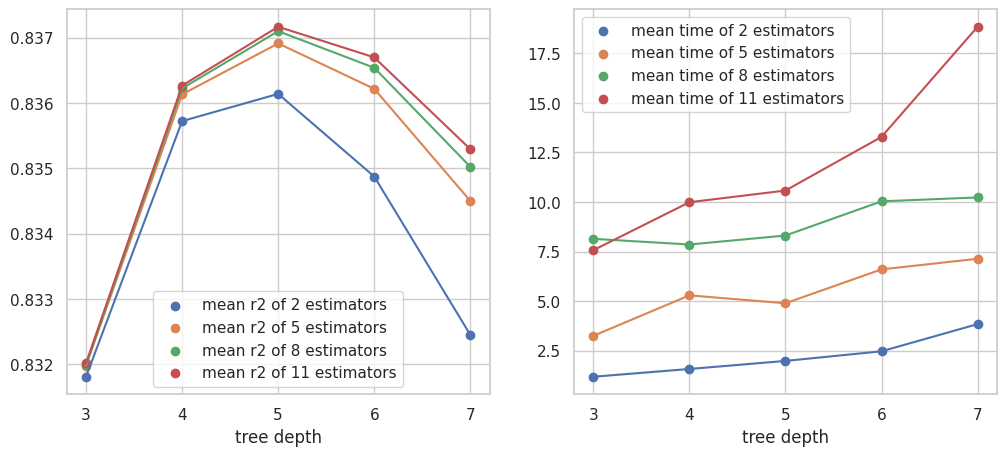

In [50]:
def report(report):
  result = {
      'mean_fit_time': report['mean_fit_time'],
      'std_fit_time': report['std_fit_time'],
      'mean_test_score': report['mean_test_score'],
      'std_test_score': report['std_test_score']
  }
  return result

def slice_list_to_n_lists(lst, n):
    list_2d = []
    for i in range(n):
      list_2d.append([])
    for i in range(len(lst)):
      if (i < n):
        list_2d[i].append(lst[i])
      else:
        list_2d[i%n].append(lst[i])
    return list_2d

report_gbt_bagging = report(grid_result)
gradient_boosting_tree_with_bagging_r2 = report_gbt_bagging['mean_test_score']
print(report_gbt_bagging)

bagging_estimator_score = slice_list_to_n_lists(report_gbt_bagging['mean_test_score'], len(num_estimator_bagging))
bagging_estimator_time = slice_list_to_n_lists(report_gbt_bagging['mean_fit_time'], len(num_estimator_bagging))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

for i in range(len(num_estimator_bagging)):
    ax[0].scatter(tree_depth, bagging_estimator_score[i], label=f'mean r2 of {num_estimator_bagging[i]} estimators')
    ax[0].plot(tree_depth, bagging_estimator_score[i])

ax[0].legend()
ax[0].set_xticks(tree_depth)
ax[0].set_xlabel("tree depth")

for i in range(len(num_estimator_bagging)):
    ax[1].scatter(tree_depth, bagging_estimator_time[i], label=f'mean time of {num_estimator_bagging[i]} estimators')
    ax[1].plot(tree_depth, bagging_estimator_time[i])

ax[1].legend()
ax[1].set_xticks(tree_depth)
ax[1].set_xlabel("tree depth")

plt.show()

# 6. Apply test set to the best model

## 6.1. Build the best model using training data

In [59]:
print("linear_regression", max(linear_regression_r2))
print("neural_network", max(neural_network_r2))
print("decision_tree_without_bagging", max(decision_tree_without_bagging_r2))
print("decision_tree_with_bagging", max(decision_tree_with_bagging_r2))
print("gradient_boosting_tree_without_bagging", max(gradient_boosting_tree_without_bagging_r2))
print("gradient_boosting_tree_with_bagging", max(gradient_boosting_tree_with_bagging_r2))

tree_depth = [5]
num_estimator_gbt = [50]
num_estimator_bagging = [11]

def BuildTrainBestModel(tree_depth_list, num_estimator_gbt_list, num_estimator_bagging_list):
  param_grid = {
      'estimator__max_depth': tree_depth_list,
      'estimator__n_estimators': num_estimator_gbt_list,
      'n_estimators': num_estimator_bagging_list
  }
  gbt_reg = GradientBoostingRegressor(random_state=4211)
  bagging_reg = BaggingRegressor(estimator=gbt_reg, random_state=4211)
  grid_search = GridSearchCV(bagging_reg, param_grid, cv=3, scoring='r2')
  grid_search.fit(selected_features_for_GBT, train_data['lengthofstay'])
  grid_result = grid_search.cv_results_

  return grid_search, grid_result

best_reg, grid_result = BuildTrainBestModel(tree_depth, num_estimator_gbt, num_estimator_bagging)

linear_regression 0.3594061008941961
neural_network [0.82011764]
decision_tree_without_bagging 0.8213609374218592
decision_tree_with_bagging 0.8293317434583205
gradient_boosting_tree_without_bagging 0.8368081608563251
gradient_boosting_tree_with_bagging 0.8371671944192682


## 6.2. Evaluate the best model using test data

In [73]:
test_data_for_best_model = test_data.copy(deep=True)

train_data_for_GBT_bagging[numerical_selected_features_name_list] = preprocessing.scale(train_data_for_GBT_bagging[numerical_selected_features_name_list])
selected_features_for_GBT = pd.get_dummies(data = train_data_for_GBT_bagging[selected_feature_name])
selected_features_names_for_GBT = selected_features_for_GBT.columns.tolist()

numerical_selected_features_name_list = ['hematocrit', 'neutrophils', 'numberofbooleanfeatures', 'bloodureanitro']
test_data_for_best_model[numerical_selected_features_name_list] = preprocessing.scale(test_data_for_best_model[numerical_selected_features_name_list])
selected_features_for_best_model = pd.get_dummies(data = test_data_for_best_model[selected_feature_name])

test_predictions = best_reg.predict(selected_features_for_best_model)
test_r2_score = r2_score(test_data['lengthofstay'], test_predictions)
test_mse = mean_squared_error(test_data['lengthofstay'], test_predictions)

print("### Before round up")
print("The predictions are:", test_predictions)
print("The truth are:", test_data['lengthofstay'].tolist())
print(f'The r2 score is {test_r2_score}')
print(f'The mse is {test_mse}')

rounded_test_predictions = [round(num, 0) for num in test_predictions]
test_r2_score = r2_score(test_data['lengthofstay'], rounded_test_predictions)
test_mse = mean_squared_error(test_data['lengthofstay'], rounded_test_predictions)

print("### After round up")
print("The predictions are:", rounded_test_predictions)
print("The truth are:", test_data['lengthofstay'].tolist())
print(f'The r2 score is {test_r2_score}')
print(f'The mse is {test_mse}')

### Before round up
The predictions are: [1.40414675 7.5203407  6.60072113 ... 5.33828165 3.77578396 1.40463521]
The truth are: [1, 8, 6, 2, 6, 4, 8, 5, 1, 11, 9, 1, 1, 7, 4, 1, 4, 4, 7, 3, 2, 2, 8, 4, 5, 2, 5, 4, 2, 4, 5, 4, 8, 1, 1, 3, 4, 6, 5, 6, 4, 1, 4, 4, 1, 1, 6, 1, 6, 8, 1, 3, 5, 7, 5, 4, 4, 2, 1, 1, 1, 4, 12, 5, 4, 5, 4, 4, 6, 1, 10, 6, 7, 1, 2, 1, 7, 1, 2, 4, 6, 1, 1, 3, 6, 4, 5, 7, 8, 8, 4, 3, 5, 2, 1, 2, 5, 5, 1, 2, 3, 6, 7, 5, 7, 8, 1, 8, 6, 4, 7, 1, 4, 6, 8, 3, 8, 7, 3, 2, 5, 3, 2, 9, 4, 1, 2, 1, 1, 4, 1, 4, 5, 3, 3, 4, 4, 3, 8, 8, 4, 6, 5, 2, 3, 5, 1, 4, 6, 4, 5, 11, 3, 1, 4, 5, 4, 2, 5, 5, 8, 2, 7, 3, 1, 6, 3, 8, 3, 6, 4, 4, 6, 7, 7, 1, 6, 5, 6, 6, 6, 2, 9, 5, 1, 5, 4, 1, 1, 3, 5, 1, 2, 3, 2, 5, 3, 3, 1, 3, 4, 3, 3, 7, 4, 4, 4, 5, 3, 3, 7, 7, 9, 4, 5, 5, 8, 3, 5, 1, 1, 4, 3, 3, 8, 6, 7, 4, 5, 5, 11, 7, 6, 4, 4, 1, 10, 5, 6, 1, 3, 3, 4, 4, 4, 6, 6, 3, 5, 1, 1, 2, 1, 3, 3, 6, 4, 2, 3, 9, 1, 4, 1, 8, 4, 4, 2, 6, 1, 2, 3, 1, 5, 4, 3, 1, 5, 9, 2, 3, 8, 4, 3, 8, 2, 6, 2, 6, 8